Import some libraries

In [ ]:
!pip install pyyaml h5py

In [ ]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
import cv2

Downloading the Dataset

In [ ]:
!wget https://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar


Extract files

In [ ]:
import tarfile
tar = tarfile.open("fishRecognition_GT.tar")
tar.extractall()
tar.close()

Read the DATA and store it to x and y

In [ ]:
path = '/content/fish_image'
categories = os.listdir(path)
categories.sort()
classes = len(categories)
size = 0
for cat in categories:
  size = size+len(os.listdir('/content/fish_image/'+cat))

i = 0
p = 0
x = np.zeros((size, 112, 112, 3), dtype=np.float32)
y = np.zeros((size, classes), dtype=np.float32)
for categorie in categories:
  ph = path + '/' + categorie
  img_dir = os.listdir(ph)
  img_dir.sort()
  for dir in img_dir:
    z = cv2.resize(cv2.imread(ph + '/' + dir),(112, 112))
    x[p,:,:,:] = z/256.
    y[p,i] = 1
    p += 1
  i += 1
  

Split the DATA

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 1)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size =0.2, random_state = 1 )

In [ ]:
print(x.shape)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

Define the model 'VGG16'

In [ ]:
# define cnn model 'using VGG16'
def define_model(classes):
    # load model
    model = VGG16(include_top=False, input_shape=(112, 112, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(classes, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = Adam(lr=1e-4)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam

model = define_model(classes)


DATA augmentation using ImageDataGenrator 

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=False, rotation_range=20, 
                             width_shift_range=0.2,height_shift_range=0.2,
                             horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

Callback for saving each epoch

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Fitting the model

In [ ]:
if os.path.exists('/content/my_model.h5')==False:
  history = model.fit(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32, epochs=5,callbacks=[cp_callback], validation_data=(X_val,y_val))
  model.save('my_model.h5')
else :
  model = tf.keras.models.load_model('my_model.h5')

In [ ]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc_test))

257/257 - 683s - loss: 0.1972 - accuracy: 0.9442
Untrained model, accuracy: 94.42%


In [ ]:
ypred = model.predict(X_test)
print(ypred)

Testing the model

In [ ]:
i=int(input("Enter the index of any picture from the test batch to predict ie. enter a number from 0 to 15326 (de X_train) :  "))
print("\nPrediction: \n",ypred[i])
print("\nActual: \n",y_test[i])
imshow(X_test[i])

In [ ]:
labels=['fish_01','fish_02','fish_03','fish_04','fish_05','fish_06','fish_07','fish_08','fish_09','fish_10','fish_11','fish_12','fish_13','fish_14','fish_15','fish_16','fish_17','fish_18','fish_19','fish_20','fish_21','fish_22','fish_23',]
plt.figure(figsize=(20,8))
plt.bar(labels,y_test[i])                          
plt.bar(labels,ypred[i])

Accuracy and Loss plotting

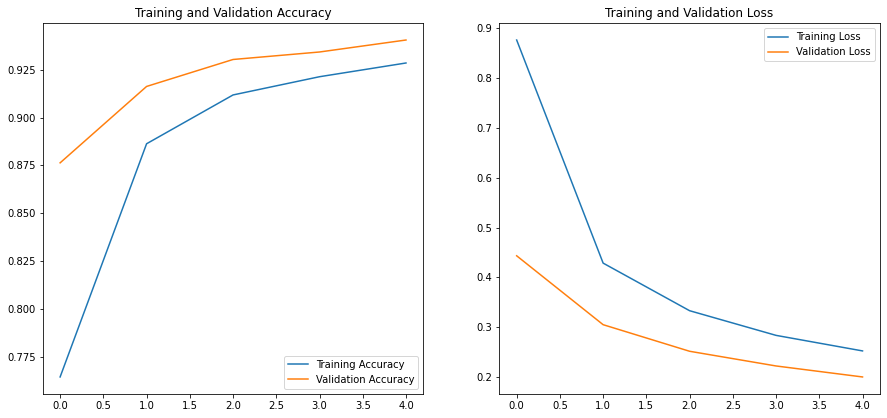

In [ ]:
acc = history.history['accuracy']             #Train accuracy
val_acc = history.history['val_accuracy']     #Validation accuracy
loss = history.history['loss']                #Train loss
val_loss = history.history['val_loss']        #Validation loss


epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
